In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from datetime import datetime
print(f'Current Step #01 [now = {datetime.now()}')


Current Step #01 [now = 2025-06-18 22:09:22.397675


In [30]:
results = {}

In [31]:
def lstm_predict(train_X, train_y, test_X):
    """ lstm_predict """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(10, 1))) # 50 LSTM units
    model.add(Dense(1)) # Output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    # Train the model
    model.fit(train_X, train_y, epochs=100, verbose=0)
    # Make predictions
    X_test = np.random.rand(5, 10, 1)
    predictions = model.predict(test_X)
    return predictions

In [32]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    metrics = metrics[0].split('|')
    return metrics[0], metrics[1]


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    for i in rounds_str.split(','):
        rounds.append(int(i))
    for i in matched_cnts_str.split(','):
        matched_cnts.append(int(i))
    rounds.reverse()
    matched_cnts.reverse()
    df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
    return df


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [24]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


```python
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout,  Dense
from tensorflow.keras.regularizers import l1_l2, l2

total_words = 478
max_sequence_len = 90
model = Sequential()
Layer1 = model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
Layer2 = model.add(Bidirectional(LSTM(20, return_sequences=True)))
Layer3 = model.add(Dropout(.03))
Layer4 = model.add(LSTM(20))
Layer5 = model.add(Dense(total_words, 
    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=l2(1e-4),
    activity_regularizer=l2(1e-5)))
          # A Dense Layer including regularizers
Layer6 = model.add(Dense(total_words, activation = 'softmax'))
          
# Pick an optimizer
          
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
```

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example data
data = np.array([[1], [2], [3], [4], [5]])

# Initialize and fit-transform the scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled Data:")
print(scaled_data)

# Restore the original data using inverse_transform
restored_data = scaler.inverse_transform(scaled_data)

print("\nRestored Data:")
print(restored_data)


Scaled Data:
[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]

Restored Data:
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]


Current Step #00 [now = 2025-06-18 23:34:02.962373
Current Step #01 [now = 2025-06-18 23:34:02.962508
Current Step #02 [now = 2025-06-18 23:34:02.971402
Current Step #04 [now = 2025-06-18 23:34:02.972679
Current Step #05 [now = 2025-06-18 23:34:02.989082
Current Step #06 [now = 2025-06-18 23:34:03.069244
Current Step #07 [now = 2025-06-18 23:34:58.705398
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Squared Error: 0.5987187733014776
Current Step #08 [now = 2025-06-18 23:34:59.198550


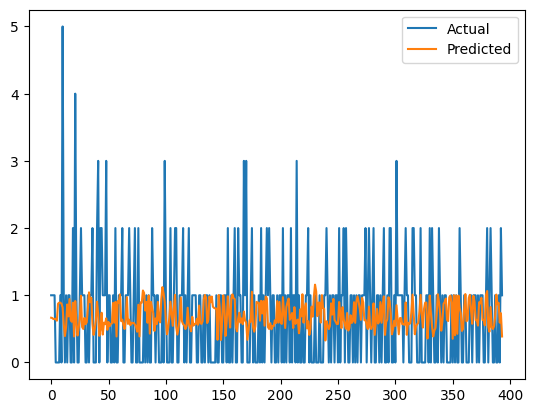

Current Step #019[now = 2025-06-18 23:34:59.274327


In [43]:
verbose = 0
print(f'Current Step #00 [now = {datetime.now()}')

version = "T_01_11"
db_file_path = '../db/metrics.db'
# random_state = 113789
random_state = 113700

print(f'Current Step #01 [now = {datetime.now()}')
df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
if verbose > 0:
    print('df', df)

print(f'Current Step #02 [now = {datetime.now()}')

# print(df)
data = df['matched_cnts'].values.reshape(-1, 1)

scaler = StandardScaler()
# scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
# scaled_data = data / 6

# print(scaled_data)

seq_length = 11
X, y = create_sequences(scaled_data, seq_length)
print(f'Current Step #04 [now = {datetime.now()}')
# 2. Model Building
tf.random.set_seed(random_state)
model = Sequential()
model.add(Input(shape=(seq_length, 1)))
k_init = tf.keras.initializers.Constant(value=0.1)
b_init = tf.keras.initializers.Constant(value=0)
r_init = tf.keras.initializers.Constant(value=0.1)
print(f'Current Step #05 [now = {datetime.now()}')
# model.add(LSTM(units=50, activation='tanh', input_shape=(seq_length, 1)))
model.add(Bidirectional(LSTM(units=50,
                             activation='tanh',
                             return_sequences=True,
                             kernel_initializer=k_init,
                             bias_initializer=b_init,
                             recurrent_initializer=r_init,
                             # return_sequences=True,
                             # return_state=True,
                             # stateful=True
                       )))
# model.add(LSTM(units=50, activation='tanh', return_sequences=True))
# model.add(LSTM(units=50, activation='tanh', return_sequences=True))
# model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(LSTM(units=50, activation='tanh'))
model.add(Dense(units=1,activation='tanh'))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(optimizer='adam', loss='binary_crossentropy')
print(f'Current Step #06 [now = {datetime.now()}')
# model.add(LSTM(units=45, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu'))
# model.add(Dense(units=1, activation='relu'))
# model.compile(optimizer='adam', loss='binary_crossentropy')
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_features, activation='sigmoid'))
    
# binary_crossentropy는 각 번호가 나올지/안나올지를 독립적으로 판단하는 다중 라벨 문제에 적합


# 3. Training
model.fit(X, y, epochs=25, batch_size=1, verbose=verbose)
print(f'Current Step #07 [now = {datetime.now()}')

# 4. Evaluation
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y)
# y_true = y_true * 6
y_pred4 = y_pred * 4
y_pred2 = y_pred * 2

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")
# print(y_pred)
# y_pred = [i * 10.0 for i in y_pred]

# print(y_pred)
print(f'Current Step #08 [now = {datetime.now()}')


plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
print(f'Current Step #019[now = {datetime.now()}')


Current Step #02 [now = 2025-06-19 00:20:42.854392
Current Step #04 [now = 2025-06-19 00:20:42.855286
Current Step #06 [now = 2025-06-19 00:20:42.855934
Current Step #08 [now = 2025-06-19 00:20:42.856057
Current Step #10 [now = 2025-06-19 00:20:42.856176
Current Step #12 [now = 2025-06-19 00:20:42.919841
Current Step #14 [now = 2025-06-19 00:25:36.189886
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Current Step #16 [now = 2025-06-19 00:25:36.811771
Current Step #18 [now = 2025-06-19 00:25:36.812659
Current Step #20 [now = 2025-06-19 00:25:36.813511
Train RMSE: 0.7365251241067392
Test RMSE: 2.6726862680763532
scaled_data 406
test_predict 80
train_predict 316


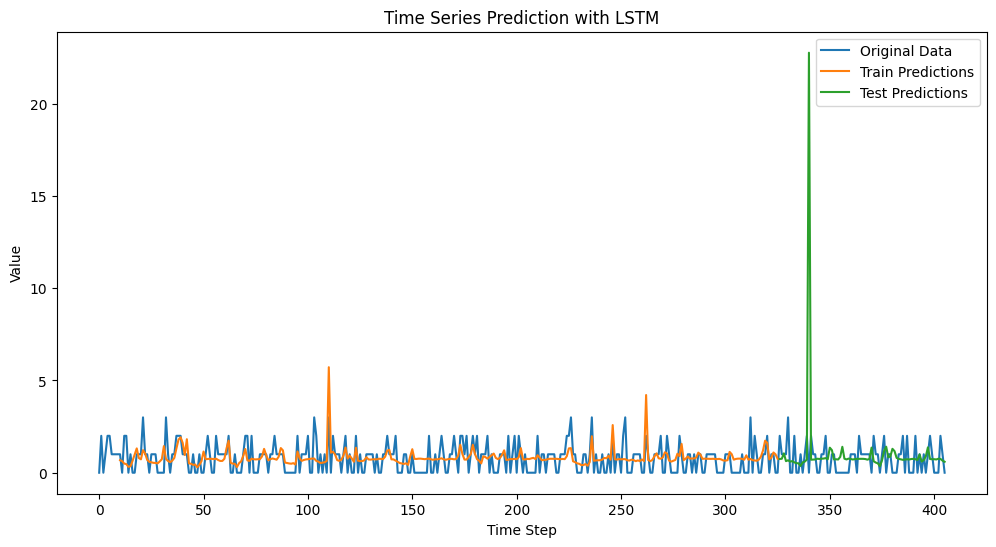

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113789
# random_state = 113700

# 1. Prepare the Data
# Create sample time series data
# data = np.array([i for i in range(1, 101)]).reshape(-1, 1)
df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
if verbose > 0:
    print('df', df)
print(f'Current Step #02 [now = {datetime.now()}')

# print(df)
data = df['matched_cnts'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f'Current Step #04 [now = {datetime.now()}')

# Define sequence length (timesteps)
sequence_length = 10

# Create sequences for training
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length, 0])
    y.append(scaled_data[i + sequence_length, 0])
X, y = np.array(X), np.array(y)
print(f'Current Step #06 [now = {datetime.now()}')

# Reshape X for LSTM input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(f'Current Step #08 [now = {datetime.now()}')

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f'Current Step #10 [now = {datetime.now()}')

# 2. Build the LSTM Model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1)) # Output layer for predicting a single value
print(f'Current Step #12 [now = {datetime.now()}')

# 3. Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0) # verbose=0 for silent training
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0) # verbose=0 for silent training
print(f'Current Step #14 [now = {datetime.now()}')

# 4. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print(f'Current Step #16 [now = {datetime.now()}')

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
print(f'Current Step #18 [now = {datetime.now()}')

# 5. Evaluate the Model (Optional, but recommended)
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
print(f'Current Step #20 [now = {datetime.now()}')

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# You can also visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(sequence_length, sequence_length + len(train_predict)), train_predict, label='Train Predictions')
plt.plot(np.arange(sequence_length + len(train_predict), sequence_length + len(train_predict) + len(test_predict)), test_predict, label='Test Predictions')
print('scaled_data',len(scaled_data))
print('test_predict',len(test_predict))
print('train_predict', len(train_predict))
plt.title('Time Series Prediction with LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Current Step #02 [now = 2025-06-19 00:43:53.560378
Current Step #04 [now = 2025-06-19 00:43:53.561206
Current Step #06 [now = 2025-06-19 00:43:53.561720
Current Step #08 [now = 2025-06-19 00:43:53.561798
Current Step #10 [now = 2025-06-19 00:43:53.561913
Current Step #12 [now = 2025-06-19 00:43:53.618684
Current Step #14 [now = 2025-06-19 00:46:08.530967
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Current Step #16 [now = 2025-06-19 00:46:09.300582
Current Step #18 [now = 2025-06-19 00:46:09.301413
Current Step #20 [now = 2025-06-19 00:46:09.302047
Train RMSE: 0.7630646989797142
Test RMSE: 0.7654220831131548
scaled_data 406
test_predict 80
train_predict 316


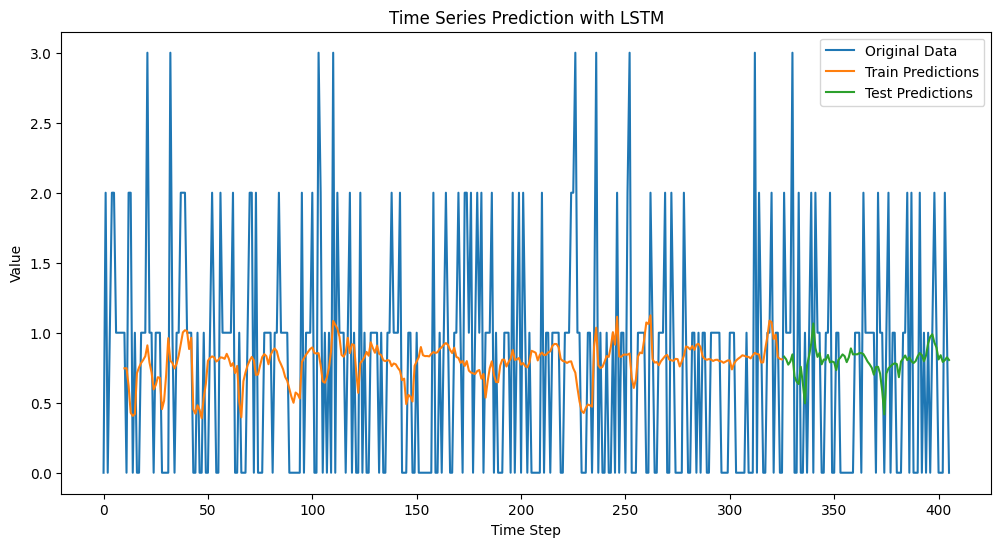

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113789
# random_state = 113700

# 1. Prepare the Data
# Create sample time series data
# data = np.array([i for i in range(1, 101)]).reshape(-1, 1)
df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
if verbose > 0:
    print('df', df)
print(f'Current Step #02 [now = {datetime.now()}')

# print(df)
data = df['matched_cnts'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f'Current Step #04 [now = {datetime.now()}')

# Define sequence length (timesteps)
sequence_length = 10

# Create sequences for training
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length, 0])
    y.append(scaled_data[i + sequence_length, 0])
X, y = np.array(X), np.array(y)
print(f'Current Step #06 [now = {datetime.now()}')

# Reshape X for LSTM input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(f'Current Step #08 [now = {datetime.now()}')

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f'Current Step #10 [now = {datetime.now()}')

# 2. Build the LSTM Model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1)) # Output layer for predicting a single value
print(f'Current Step #12 [now = {datetime.now()}')

# 3. Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0) # verbose=0 for silent training
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training
print(f'Current Step #14 [now = {datetime.now()}')

# 4. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print(f'Current Step #16 [now = {datetime.now()}')

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
print(f'Current Step #18 [now = {datetime.now()}')

# 5. Evaluate the Model (Optional, but recommended)
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
print(f'Current Step #20 [now = {datetime.now()}')

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# You can also visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(sequence_length, sequence_length + len(train_predict)), train_predict, label='Train Predictions')
plt.plot(np.arange(sequence_length + len(train_predict), sequence_length + len(train_predict) + len(test_predict)), test_predict, label='Test Predictions')
print('scaled_data',len(scaled_data))
print('test_predict',len(test_predict))
print('train_predict', len(train_predict))
plt.title('Time Series Prediction with LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

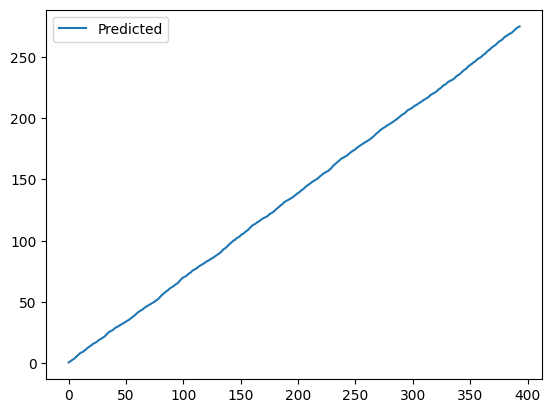

In [52]:
pre = 0
y_pred1 = []
for i in range(len(y_pred)):
    y_pred1.append(y_pred[i] + pre)
    pre += y_pred[i]
plt.plot(y_pred1, label='Predicted')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Data Preparation
df = pd.read_csv('your_time_series_data.csv')
data = df['your_time_series_column'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)



seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# 2. Model Building
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Training
model.fit(X, y, epochs=100, batch_size=32)

# 4. Evaluation
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. 데이터 준비
# 예시 데이터 생성 (실제 데이터로 교체 필요)
time_steps = 10
data_dim = 1
num_samples = 100

X = np.random.rand(num_samples, time_steps, data_dim)
y = np.random.rand(num_samples, 1)

print(X)
print(y)

# 2. 모델 구성
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, data_dim)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 3. 모델 훈련
model.fit(X, y, epochs=10, batch_size=32)

# 4. 예측
predictions = model.predict(X)

print(predictions)

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
from tqdm import tqdm

# 딥러닝 라이브러리 TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MultiLabelBinarizer

# 시퀀스 길이 (과거 몇 회차의 데이터를 보고 다음을 예측할 것인가)
SEQUENCE_LENGTH = 10


def create_sequences(data, seq_length):
    """
    데이터를 LSTM 학습에 맞는 시퀀스 형태로 변환합니다.
    """
    xs = []
    ys = []
    # Multi-hot 인코딩을 위해 1~45번까지의 클래스를 명시적으로 지정
    mlb = MultiLabelBinarizer(classes=list(range(1, 46)))
    
    # 전체 데이터를 Multi-hot 벡터로 변환
    encoded_data = mlb.fit_transform(data)
    
    for i in tqdm(range(len(encoded_data) - seq_length), desc="시퀀스 데이터 생성 중"):
        # 입력 시퀀스 (X): i부터 i+seq_length-1 까지
        xs.append(encoded_data[i:(i + seq_length)])
        # 타겟 (y): i+seq_length
        ys.append(encoded_data[i + seq_length])
        
    return np.array(xs), np.array(ys), mlb


def build_lstm_model(seq_length, num_features, neural_num=128, verbose=0, activation='sigmoid'):
    """
    LSTM 모델을 생성합니다.
    """
    model = Sequential()
    # 입력층: LSTM 레이어, input_shape=(시퀀스 길이, 피처 개수)
    model.add(LSTM(neural_num, return_sequences=True, activation=activation, input_shape=(seq_length, num_features)))
    model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    # model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    model.add(Dropout(0.2))
    # 중간층: LSTM 레이어
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    # 출력층으로 가기 전 Dense 레이어
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_features, activation='sigmoid'))
    
    # 모델 컴파일
    # binary_crossentropy는 각 번호가 나올지/안나올지를 독립적으로 판단하는 다중 라벨 문제에 적합
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    if verbose > 0:
        model.summary()
    return model


file_names = [
    (1174, 'xlsx/1173.xlsx', [8, 11, 14, 17, 36, 39]),
    (1175, 'xlsx/1174.xlsx', [3, 4, 6, 8, 32, 42]),
    (1176, 'xlsx/1175.xlsx', [0, 0, 0, 0, 0, 0])
    ]



for file_name in file_names:
    # --- 코드 실행 ---
    # 1. 역대 당첨 번호 데이터 가져오기
    lotto_history = get_lotto_history(*file_name, row_end=10)
    if lotto_history is not None:
        neural_num = 64
        # 2. 데이터 전처리 및 시퀀스 생성
        X, y, mlb = create_sequences(lotto_history, SEQUENCE_LENGTH)
    
        # 3. LSTM 모델 빌드
        # num_features는 로또 번호의 개수(45)
        model = build_lstm_model(SEQUENCE_LENGTH, X.shape[2], neural_num=neural_num)
    
        # 4. 모델 학습 (데이터가 많아 시간이 소요될 수 있습니다)
        print("\nLSTM 모델 학습을 시작합니다...")
        model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    
        # 5. 1176회 예측
        print(f"\{file_name[0]}회 예측을 시작합니다...")
    
        # 예측을 위해 가장 마지막 시퀀스를 입력으로 사용
        last_sequence_raw = lotto_history[-SEQUENCE_LENGTH:]
        last_sequence_encoded = mlb.transform(last_sequence_raw)
    
        # Keras 모델은 배치 입력을 기대하므로 차원을 추가 (samples, timesteps, features)
        input_for_prediction = np.expand_dims(last_sequence_encoded, axis=0)
    
        # 예측 실행 (결과는 각 번호가 나올 확률)
        predicted_probabilities = model.predict(input_for_prediction)[0]
    
        # 확률이 높은 순으로 6개 번호의 인덱스를 추출
        # argsort는 값을 정렬했을 때의 원래 인덱스를 반환
        top_6_indices = np.argsort(predicted_probabilities)[-6:]
    
        # 인덱스는 0부터 시작하므로 1을 더해 실제 로또 번호로 변환
        predicted_numbers = sorted([int(i + 1) for i in top_6_indices])
        if file_name[0] not in results:
            results[file_name[0]] = [predicted_numbers]
        else:
            results[file_name[0]].append(predicted_numbers)
    
        print("\n--- 최종 예측 결과 ---")
        print(f"LSTM 모델 기반 {file_name[0]}회 예측 번호: {predicted_numbers} {neural_num}, ")

In [ ]:
version = "T_01_10"
db_file_path = '../db/metrics.db'
random_state = 113789
metrics = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
print(metrics)

In [ ]:
for result in results:
    print("라운드", result)
    for metric in results[result]:
        print(metric)

In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]